## Feature Relevance analysis

In [1]:
import sys
import os
import time
import multiprocessing
import pprint 

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from Packages.NoveltyDetection.setup.noveltyDetectionConfig import CONFIG
from NNNoveltyDetectionAnalysis import NNNoveltyDetectionAnalysis
from Functions.telegrambot import Bot

num_processes = multiprocessing.cpu_count()

from Functions.telegrambot import Bot

my_bot = Bot("lisa_thebot")

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

training_params = {
    "Technique": "NeuralNetwork",
    "DevelopmentMode": False,
    "DevelopmentEvents": 400,
}
analysis = NNNoveltyDetectionAnalysis(parameters=training_params, 
                                      model_hash="09862c788e5407f27ba6907020be508103b7c32a8bde2875b24d33b0ffe646cb",#"288861ff98f11a0dc05b9fbd92375a80a22fe13671458441e5adc5cd38eea319", 
                                      load_hash=True, load_data=True, verbose=True)
all_data, all_trgt, all_trgt_sparse = analysis.getData()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

models = analysis.models

Using TensorFlow backend.


Reading from C:\Users\vinic\Workspace\LPS\SonarAnalysis\Results\NoveltyDetection\NeuralNetwork\outputs\09862c788e5407f27ba6907020be508103b7c32a8bde2875b24d33b0ffe646cb\parameters.json
[+] Time to read data file: 1.7559335231781006 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
Total of events in the dataset is 77561
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)
Reading from C:\Users\vinic\Workspace\LPS\SonarAnalysis\Results\NoveltyDetection\4_folds_cross_validation_balanced_data.jbl
Reading from C:\Users\vinic\Workspace\LPS\SonarAnalysis\Results\NoveltyDetection\4_folds_cross_validation_balanced_data.jbl


In [6]:
pp = pprint.PrettyPrinter(indent=1)
print(analysis.model_hash)
print(analysis.getBaseResultsPath())
pp.pprint(analysis.parameters)

09862c788e5407f27ba6907020be508103b7c32a8bde2875b24d33b0ffe646cb
C:\Users\vinic\Workspace\LPS\SonarAnalysis\Results\NoveltyDetection\NeuralNetwork\outputs\09862c788e5407f27ba6907020be508103b7c32a8bde2875b24d33b0ffe646cb
{'DevelopmentEvents': 400,
 'DevelopmentMode': False,
 'HyperParameters': {'batch_size': 256,
                     'classifier_output_activation_function': 'softmax',
                     'dropout': False,
                     'dropout_parameter': 0.0,
                     'hidden_activation_function': 'tanh',
                     'kernel_initializer': 'uniform',
                     'loss': 'mean_squared_error',
                     'metrics': ['accuracy'],
                     'n_epochs': 200,
                     'n_folds': 4,
                     'n_inits': 2,
                     'norm': 'mapstd',
                     'regularization': None,
                     'regularization_parameter': 0.0},
 'InputDataConfig': {'balance_data': True,
                     'datab

### Relevance analysis based on suppressing features and evaluating the performance of the model

In [7]:
from sklearn import preprocessing
from sklearn.externals import joblib

from Functions.sp_index import sp_index

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [50]

inovelty = 0

# step = 5
# neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
# neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

neurons_str = models[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
analysis_name = 'feature_relevance_analysis_{}_layer_{}'.format(layer, neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

n_bins = all_data.shape[1]
sp_per_bin = np.zeros((len(analysis.class_labels),analysis.n_folds,n_bins))
reference_sp = np.zeros((len(analysis.class_labels),analysis.n_folds))

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        print("Novelty Class: {}".format(analysis.class_labels[inovelty]))
        for ifold in range(analysis.n_folds):
            print("Fold: {}".format(ifold))
            train_id, test_id = analysis.CVO[inovelty][ifold]

            # normalize known classes
            if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_target = analysis.trn_trgt[inovelty][test_id]
            
            #Import model
            print("Loading model...")
            classifier = models[inovelty].get_model(data  = analysis.trn_data[inovelty],
                                                    trgt  = analysis.trn_trgt[inovelty], 
                                                    hidden_neurons = hidden_neurons[:layer],
                                                    layer = layer,
                                                    ifold = ifold
                                                   )
            
            print("Classifier loaded with success.")
            
            output = classifier.predict(known_data)
            reference_sp[inovelty, ifold] =  sp_index(known_target, np.argmax(output, axis=1))
            
            for ibin in range(n_bins):
                temp_known_data = np.copy(known_data)
                temp_known_data[:,ibin] = 0
                #Get model output
                output = classifier.predict(temp_known_data)
                #Get SP
                sp_per_bin[inovelty, ifold, ibin] = sp_index(known_target, np.argmax(output, axis=1))
    joblib.dump([reference_sp, sp_per_bin],analysis_file,compress=9)
    my_bot.sendMessage("Got SP for relevance analysis!")
else: 
    reference_sp, sp_per_bin = joblib.load(analysis_file)

Novelty Class: A
Fold: 0
Loading model...
Classifier loaded with success.
Fold: 1
Loading model...
Classifier loaded with success.
Fold: 2
Loading model...
Classifier loaded with success.
Fold: 3
Loading model...
Classifier loaded with success.
Novelty Class: B
Fold: 0
Loading model...
Classifier loaded with success.
Fold: 1
Loading model...
Classifier loaded with success.
Fold: 2
Loading model...
Classifier loaded with success.
Fold: 3
Loading model...
Classifier loaded with success.
Novelty Class: C
Fold: 0
Loading model...
Classifier loaded with success.
Fold: 1
Loading model...
Classifier loaded with success.
Fold: 2
Loading model...
Classifier loaded with success.
Fold: 3
Loading model...
Classifier loaded with success.
Novelty Class: D
Fold: 0
Loading model...
Classifier loaded with success.
Fold: 1
Loading model...
Classifier loaded with success.
Fold: 2
Loading model...
Classifier loaded with success.
Fold: 3
Loading model...
Classifier loaded with success.


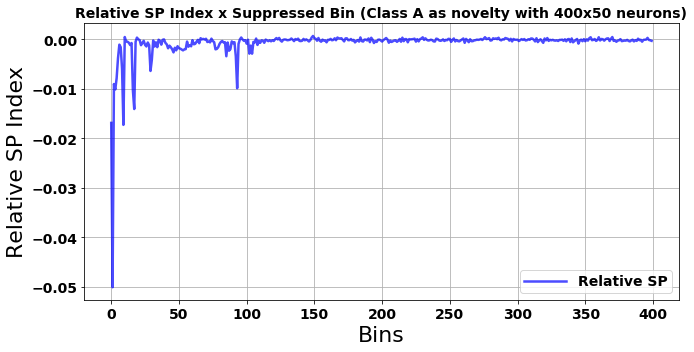

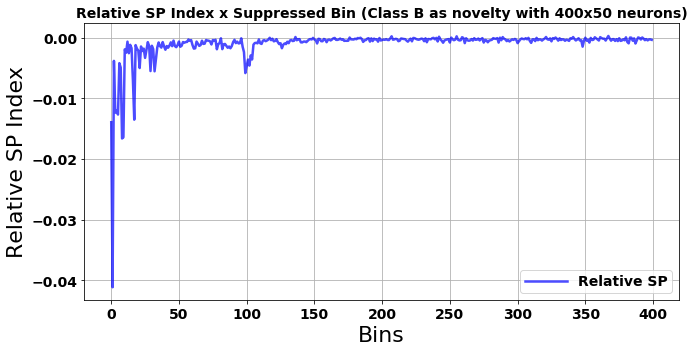

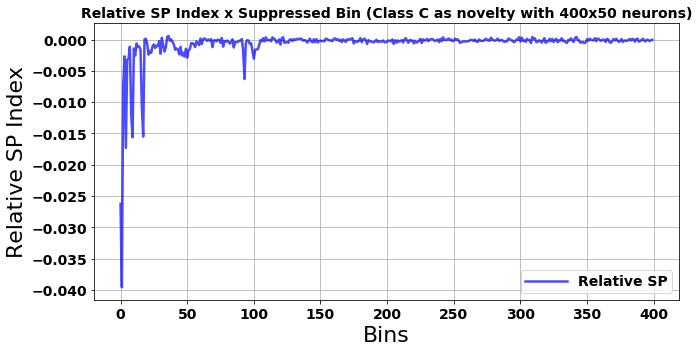

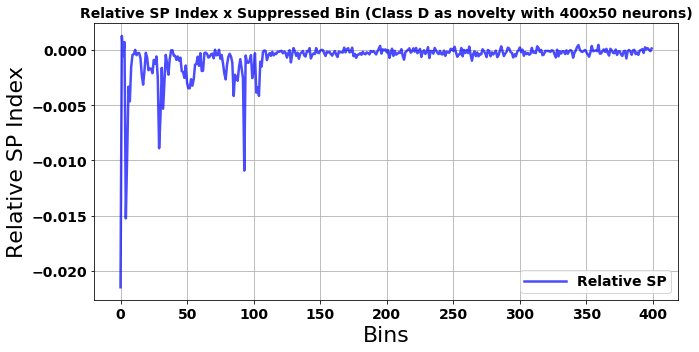

In [9]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
import matplotlib.pyplot as plt

# Plot 
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)

for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    reference_mean_sp = np.mean(reference_sp[inovelty,:], axis=0)
    mean_sp = np.mean(sp_per_bin[inovelty,:], axis=0)
    error_sp = np.std(sp_per_bin[inovelty,:,:], axis=0)
    
    relative_sp = (mean_sp-(np.ones(mean_sp.shape)*reference_mean_sp))
    
    bins = list(range(all_data.shape[1]))
    
    ax.plot(bins, relative_sp, color='b', alpha=0.7, linewidth=2.5, label='Relative SP')
    
    # ax.fill_between(bins, relative_sp+error_sp, relative_sp-error_sp, facecolor='blue', alpha=0.3)
    
    ax.set_title('Relative SP Index x Suppressed Bin (Class {} as novelty with {} neurons)'.format(analysis.class_labels[inovelty], neurons_str),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('Relative SP Index', fontsize=22)
    ax.set_xlabel('Bins', fontsize=22)
    ax.grid()
    ax.legend()
    plt.tight_layout()
    #Save the figure
    neurons_str = models[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
    plt.savefig(file_name, format="png")
    try: 
        my_bot.sendMessage(imgPath=file_name)
    except Exception as e:
        print("Error when sending the image to the bot. Error: {}".format(str(e)))
